In [3]:
import pandas as pd 
import os
import numpy as np
from skimage.io import imread
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception, EfficientNetB0, vgg16
import itertools

In [4]:
df = pd.read_csv('/home/giorgia/Desktop/MAI/Thesis/patch_info.csv')
len(df[df.plastic!=-1])
df = pd.read_csv('/home/giorgia/Desktop/MAI/Thesis/patch_info.csv')
df = df[df.plastic!=-1]
df_plastic = df[df.plastic==1].reset_index()
df_noplastic = df[df.plastic==0].reset_index()
len(df_plastic), len(df_noplastic)

(611, 690)

In [5]:
partition = 0.90

rand_ind_p = np.random.randint(0, len(df_plastic), int(partition*len(df_plastic)))
rand_ind_np = np.random.randint(0, len(df_noplastic), int(partition*len(df_noplastic)))

training_set = pd.concat([df_plastic.loc[rand_ind_p, ['patch_filename', 'plastic']], df_noplastic.loc[rand_ind_np, ['patch_filename', 'plastic']]]).reset_index()
validation_set = pd.merge(df.loc[:, ['patch_filename', 'plastic']], training_set, indicator=True, how='outer').query('_merge=="left_only"').drop(['_merge','index'], axis=1).reset_index()

len(training_set), len(validation_set)

(1170, 548)

In [6]:
def prepareDataNN(df):
    data = []
    labels = []
    patches_path = '/home/giorgia/Desktop/MAI/Thesis/images/patches/'
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        #im = np.amax(imread(patch_filename), axis=2) # maximum intensity projection
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            data.append(im)
            labels.append(np.array(df.loc[i, 'plastic']))
    return data, labels

In [19]:
def get_preditictions(model, test_data):
    pred_prob = model.predict(np.array(test_data))
    pred_class = []
    for p in pred_prob:
        if p >= .5:
            pred_class.append(1)
        else:
            pred_class.append(0)
    print(classification_report(test_labels, pred_class))
    return (pred_prob, pred_class)

## Simple CNN

In [7]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      #layers.RandomTranslation(0.8, 0.5),
      #layers.RandomZoom(0.5),
      layers.RandomContrast(0.7),
    ]
)

2022-02-16 16:51:07.959037: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-16 16:51:07.959120: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (giorgia-PX60-6QE): /proc/driver/nvidia/version does not exist
2022-02-16 16:51:07.982811: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
def make_model(input_shape):
    inputs = keras.Input(shape = input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Architecture 
    x = layers.Rescaling(1.0 / 255)(x)
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

image_size = (256, 256, 3) 
model = make_model(input_shape=image_size)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [8]:
training_data, training_labels = prepareDataNN(training_set)
test_data, test_labels = prepareDataNN(validation_set)

In [21]:
model.load_weights("ckpts/save_at_391.h5")
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
pred_probs_cnn, pred_class_xìcnn = get_preditictions(model, test_data)

              precision    recall  f1-score   support

         0.0       0.70      0.97      0.81       239
         1.0       0.95      0.60      0.74       245

    accuracy                           0.78       484
   macro avg       0.83      0.79      0.78       484
weighted avg       0.83      0.78      0.78       484



## Transfer Learning

### Training Xception

In [14]:
# preprocess data 
inputs = keras.Input(shape = (256, 256, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)

# load pre-trained model and weights without last layer
x = Xception(weights=None, include_top=False, input_shape=(256, 256, 3))(x)

# add layers on top
x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# final model to train
tf_model_xception = keras.Model(inputs, outputs)


In [14]:
epochs = 100
callbacks = [
    keras.callbacks.ModelCheckpoint("ckpts/tf_xception_{epoch}.h5", save_best_only=True),
]
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs',
                 histogram_freq=1, 
                 write_graph=True, 
                 write_images=False)

tf_model_xception.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
tf_model_xception.fit(
    x =np.array(training_data), y=np.array(training_labels), epochs=epochs, callbacks=[callbacks, tensorboard], validation_split = .15, batch_size=32
)

Epoch 1/100
24/24 [==============================] - 258s 11s/step - loss: 0.7461 - accuracy: 0.6836 - val_loss: 0.6980 - val_accuracy: 0.0000e+00
Epoch 2/100
24/24 [==============================] - 250s 10s/step - loss: 0.5198 - accuracy: 0.7574 - val_loss: 0.6721 - val_accuracy: 1.0000
Epoch 3/100
24/24 [==============================] - 253s 11s/step - loss: 0.4854 - accuracy: 0.7681 - val_loss: 0.6910 - val_accuracy: 1.0000
Epoch 4/100
24/24 [==============================] - 250s 10s/step - loss: 0.5044 - accuracy: 0.7493 - val_loss: 0.6585 - val_accuracy: 1.0000
Epoch 5/100
24/24 [==============================] - 272s 11s/step - loss: 0.4834 - accuracy: 0.7587 - val_loss: 0.6409 - val_accuracy: 1.0000
Epoch 6/100
24/24 [==============================] - 280s 12s/step - loss: 0.5420 - accuracy: 0.7091 - val_loss: 0.6776 - val_accuracy: 1.0000
Epoch 7/100
24/24 [==============================] - 294s 12s/step - loss: 0.4492 - accuracy: 0.7882 - val_loss: 0.4872 - val_accuracy: 1.

In [17]:
# load weights of trained model and compile 
tf_model_xception.load_weights("ckpts/tf_xception_14.h5")
tf_model_xception.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
pred_probs_x, pred_class_x = get_preditictions(tf_model_xception, test_data)

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.66       239
         1.0       0.00      0.00      0.00       245

    accuracy                           0.49       484
   macro avg       0.25      0.50      0.33       484
weighted avg       0.24      0.49      0.33       484



/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Training EfficientNetB0

In [10]:
# preprocess data 
inputs = keras.Input(shape = (256, 256, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)

# load pre-trained model and weights without last layer
x = EfficientNetB0(weights=None, include_top=False, input_shape=(256, 256, 3))(x)

# add layers on top
x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
# final model to train
tf_model_eff = keras.Model(inputs, outputs)

In [24]:
epochs = 100
callbacks = [
    keras.callbacks.ModelCheckpoint("ckpts/tf_effnetb0_{epoch}.h5", save_best_only=True),
]
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs',
                 histogram_freq=1, 
                 write_graph=True, 
                 write_images=False)

tf_model_eff.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
tf_model_eff.fit(
    x =np.array(training_data), y=np.array(training_labels), epochs=epochs, callbacks=[callbacks, tensorboard], validation_split = .15, batch_size=32
)

Epoch 1/100
28/28 [==============================] - 150s 5s/step - loss: 0.6886 - accuracy: 0.6335 - val_loss: 0.4634 - val_accuracy: 1.0000
Epoch 2/100
28/28 [==============================] - 146s 5s/step - loss: 0.5633 - accuracy: 0.6946 - val_loss: 0.4483 - val_accuracy: 1.0000
Epoch 3/100
28/28 [==============================] - 132s 5s/step - loss: 0.5547 - accuracy: 0.7296 - val_loss: 0.4323 - val_accuracy: 1.0000
Epoch 4/100
28/28 [==============================] - 133s 5s/step - loss: 0.5173 - accuracy: 0.7523 - val_loss: 0.2799 - val_accuracy: 1.0000
Epoch 5/100
28/28 [==============================] - 129s 5s/step - loss: 0.4931 - accuracy: 0.7477 - val_loss: 0.0848 - val_accuracy: 1.0000
Epoch 6/100
28/28 [==============================] - 124s 4s/step - loss: 0.4523 - accuracy: 0.7828 - val_loss: 0.0572 - val_accuracy: 1.0000
Epoch 7/100
28/28 [==============================] - 124s 4s/step - loss: 0.4585 - accuracy: 0.7828 - val_loss: 0.1806 - val_accuracy: 1.0000
Epoch 

In [12]:

tf_model_eff.load_weights("ckpts/tf_effnetb0_8.h5")
tf_model_eff.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
pred_probs_eff, pred_class_eff = get_preditictions(tf_model_eff, test_data)

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.66       239
         1.0       0.00      0.00      0.00       245

    accuracy                           0.49       484
   macro avg       0.25      0.50      0.33       484
weighted avg       0.24      0.49      0.33       484



/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

Text(0.5, 0, 'Recall')

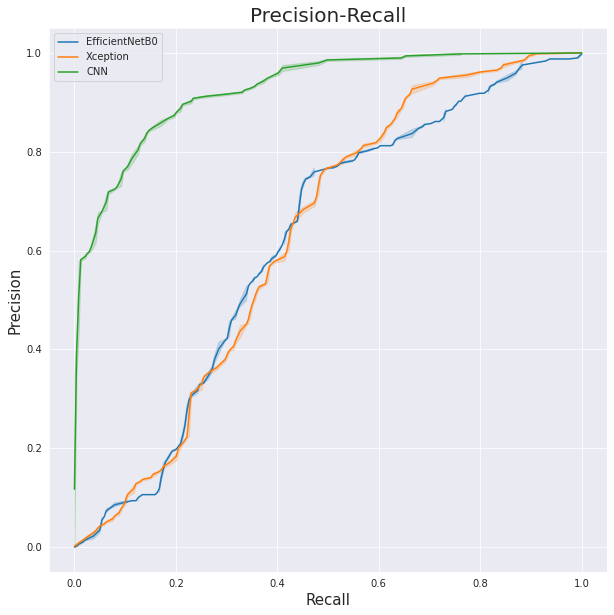

In [22]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve

import seaborn as sns 

plt.figure(figsize=(10,10))
plt.title("Precision-Recall", fontsize=20)
sns.set_style("darkgrid")
# CNN
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_eff)
sns.lineplot(fpr, tpr, label="EfficientNetB0")

sns.set_style("darkgrid")
# Xception
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_x)
sns.lineplot(fpr, tpr, label="Xception")
plt.legend()

sns.set_style("darkgrid")
# CNN
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_cnn)
sns.lineplot(fpr, tpr, label="CNN")
plt.legend()


plt.ylabel("Precision", fontsize=15)
plt.xlabel("Recall", fontsize=15)